
# 分类特征稀疏的文本

>翻译者:[@Loopy](https://github.com/loopyme)        
>校验者:[@barrycg](https://github.com/barrycg)

这个例子展示了如何使用scikit-learn中的单词包方法，根据主题对文档进行分类。本例使用scipy.sparse中的矩阵来存储特征，并演示各种能够有效处理稀疏矩阵的分类器。

本例中使用的数据集是20条新闻组数据集。通过scikit-learn可以自动下载该数据集，并进行缓存。

下述条形图展示了各个不同分类器，其信息包括精度、训练时间(已归一化)和测试时间(已归一化)。


In [ ]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [ ]:
# 在stdout上显示进度日志
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

In [ ]:
# 解析命令行参数
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")





    <Option at 0x7febca4f9320: --filtered>





In [ ]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

In [ ]:
# Jupyter notebook上的运行方法
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

    Automatically created module for IPython interactive environment
    Usage: ipykernel_launcher.py [options]

    Options:
      -h, --help            show this help message and exit
      --report              Print a detailed classification report.
      --chi2_select=SELECT_CHI2
                            Select some number of features using a chi-squared
                            test
      --confusion_matrix    Print the confusion matrix.
      --top10               Print ten most discriminative terms per class for
                            every classifier.
      --all_categories      Whether to use all categories or not.
      --use_hashing         Use a hashing vectorizer.
      --n_features=N_FEATURES
                            n_features when using the hashing vectorizer.
      --filtered            Remove newsgroup information that is easily overfit:
                            headers, signatures, and quoting.





In [ ]:
# 从训练集中加载一些类别
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

In [ ]:
if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

    Loading 20 newsgroups dataset for categories:
    ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']



In [ ]:
# 下载数据集
data_train = fetch_20newsgroups(subset='train', categories=categories,shuffle=True, random_state=42,remove=remove)
data_test = fetch_20newsgroups(subset='test', categories=categories,shuffle=True, random_state=42,remove=remove)

In [ ]:
# target_names中的标签顺序可以与categories中的不同
target_names = data_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))

    2034 documents - 3.980MB (training set)
    1353 documents - 2.867MB (test set)
    4 categories



In [ ]:
# 划分测试,训练集
y_train, y_test = data_train.target, data_test.target

In [ ]:
print("使用稀疏向量机从训练数据中提取特征")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

    使用稀疏向量机从训练数据中提取特征
    done in 0.476004s at 8.360MB/s
    n_samples: 2034, n_features: 33809



In [ ]:
print("使用相同的矢量化器从测试数据中提取特征")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

    使用相同的矢量化器从测试数据中提取特征
    done in 0.311447s at 9.207MB/s
    n_samples: 1353, n_features: 33809



In [ ]:
# 从整数的特征名称映射到原始的token字符串
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

In [ ]:
if opts.select_chi2:
    print("使用卡方检验提取 %d 个特征" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))

In [ ]:
if feature_names:
    feature_names = np.asarray(feature_names)

In [ ]:
# 修剪字符串以适应终端(假设显示80列)
def trim(s):
    return s if len(s) <= 80 else s[:77] + "..."

## 基准分类器


In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("训练: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("训练时间: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("最佳时间:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("准确率:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("维数: %d" % clf.coef_.shape[1])
        print("密度: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("每个类的前十个词:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("分类报告:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("混淆矩阵:")
        print(metrics.confusion_matrix(y_test, pred))

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [ ]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "岭分类器"),
        (Perceptron(max_iter=50, tol=1e-3), "感知器"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "PAC分类器"),
        (KNeighborsClassifier(n_neighbors=10), "K近邻"),
        (RandomForestClassifier(n_estimators=100), "随机森林")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

    ================================================================================
    岭分类器
    ________________________________________________________________________________
    训练:
    RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                    max_iter=None, normalize=False, random_state=None, solver='sag',
                    tol=0.01)
    训练时间: 0.202s
    最佳时间:  0.002s
    准确率:   0.897
    维数: 33809
    密度: 1.000000

    ================================================================================
    感知器
    ________________________________________________________________________________
    训练:
    Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
               fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
               penalty=None, random_state=0, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False)
    训练时间: 0.030s
    最佳时间:  0.003s
    准确率:   0.888
    维数: 33809
    密度: 0.255302

    ================================================================================
    PAC分类器
    ________________________________________________________________________________
    训练:
    PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                                early_stopping=False, fit_intercept=True,
                                loss='hinge', max_iter=50, n_iter_no_change=5,
                                n_jobs=None, random_state=None, shuffle=True,
                                tol=0.001, validation_fraction=0.1, verbose=0,
                                warm_start=False)
    训练时间: 0.063s
    最佳时间:  0.003s
    准确率:   0.902
    维数: 33809
    密度: 0.700487

    ================================================================================
    K近邻
    ________________________________________________________________________________
    训练:
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                         metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                         weights='uniform')
    训练时间: 0.002s
    最佳时间:  0.235s
    准确率:   0.858
    ================================================================================
    随机森林
    ________________________________________________________________________________
    训练:
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                           max_depth=None, max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_jobs=None, oob_score=False, random_state=None,
                           verbose=0, warm_start=False)
    训练时间: 1.752s
    最佳时间:  0.084s
    准确率:   0.822




In [ ]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s 罚项" % penalty.upper())
    # 训练Liblinear模型
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # 训练SGD model模型
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

    ================================================================================
    L2 罚项
    ________________________________________________________________________________
    训练:
    LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
              intercept_scaling=1, loss='squared_hinge', max_iter=1000,
              multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
              verbose=0)
    训练时间: 0.274s
    最佳时间:  0.003s
    准确率:   0.900
    维数: 33809
    密度: 1.000000

    ________________________________________________________________________________
    训练:
    SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                  early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                  l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
                  n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                  random_state=None, shuffle=True, tol=0.001,
                  validation_fraction=0.1, verbose=0, warm_start=False)
    训练时间: 0.050s
    最佳时间:  0.003s
    准确率:   0.899
    维数: 33809
    密度: 0.573353

    ================================================================================
    L1 罚项
    ________________________________________________________________________________
    训练:
    LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
              intercept_scaling=1, loss='squared_hinge', max_iter=1000,
              multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
              verbose=0)
    训练时间: 0.257s
    最佳时间:  0.002s
    准确率:   0.873
    维数: 33809
    密度: 0.005568

    ________________________________________________________________________________
    训练:
    SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                  early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                  l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
                  n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
                  random_state=None, shuffle=True, tol=0.001,
                  validation_fraction=0.1, verbose=0, warm_start=False)
    训练时间: 0.187s
    最佳时间:  0.003s
    准确率:   0.882
    维数: 33809
    密度: 0.023049





In [ ]:
# 训练带弹性网络(Elastic Net)罚项的SGD模型
print('=' * 80)
print("弹性网络(Elastic Net)罚项")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

    ================================================================================
    弹性网络(Elastic Net)罚项
    ________________________________________________________________________________
    训练:
    SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                  early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                  l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
                  n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
                  power_t=0.5, random_state=None, shuffle=True, tol=0.001,
                  validation_fraction=0.1, verbose=0, warm_start=False)
    训练时间: 0.295s
    最佳时间:  0.003s
    准确率:   0.897
    维数: 33809
    密度: 0.185956




In [ ]:
# 训练不带阈值的Rocchio分类器
print('=' * 80)
print("不带阈值的Rocchio分类器")
results.append(benchmark(NearestCentroid()))

    ================================================================================
    不带阈值的Rocchio分类器
    ________________________________________________________________________________
    训练:
    NearestCentroid(metric='euclidean', shrink_threshold=None)
    训练时间: 0.007s
    最佳时间:  0.002s
    准确率:   0.855



In [ ]:
# 训练稀疏朴素贝叶斯分类器
print('=' * 80)
print("稀疏朴素贝叶斯分类器")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

    ================================================================================
    稀疏朴素贝叶斯分类器
    ________________________________________________________________________________
    训练:
    MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
    训练时间: 0.007s
    最佳时间:  0.003s
    准确率:   0.899
    维数: 33809
    密度: 1.000000

    ________________________________________________________________________________
    训练:
    BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
    训练时间: 0.010s
    最佳时间:  0.008s
    准确率:   0.884
    维数: 33809
    密度: 1.000000

    ________________________________________________________________________________
    训练:
    ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=False)
    训练时间: 0.007s
    最佳时间:  0.002s
    准确率:   0.911
    维数: 33809
    密度: 1.000000





In [ ]:
print('=' * 80)
print("基于l1的特征选择的LinearSVC")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

    ================================================================================
    基于l1的特征选择的LinearSVC
    ________________________________________________________________________________
    训练:
    Pipeline(memory=None,
             steps=[('feature_selection',
                     SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         loss='squared_hinge',
                                                         max_iter=1000,
                                                         multi_class='ovr',
                                                         penalty='l1',
                                                         random_state=None,
                                                         tol=0.001, verbose=0),
                                     max_features=None, norm_order=1, prefit=False,
                                     threshold=None)),
                    ('classification',
                     LinearSVC(C=1.0, class_weight=None, dual=True,
                               fit_intercept=True, intercept_scaling=1,
                               loss='squared_hinge', max_iter=1000,
                               multi_class='ovr', penalty='l2', random_state=None,
                               tol=0.0001, verbose=0))],
             verbose=False)
    训练时间: 0.277s
    最佳时间:  0.002s
    准确率:   0.880



In [ ]:
# 参考翻译
classifier_dic={
    'RidgeClassifier':'岭分类器(Ridge)',
    'Perceptron':'感知器(Perceptron)',
    'PassiveAggressiveClassifier':'PAC分类器',
    'KNeighborsClassifier':'K近邻(KNN)',
    'RandomForestClassifier':'随机森林',
    'LinearSVC':'线性SVC',
    'SGDClassifier':'SGD分类器',
    'NearestCentroid':'线性SVC',
    'MultinomialNB':'(多项式)稀疏朴素贝叶斯分类器',
    'BernoulliNB':'(伯努利)稀疏朴素贝叶斯分类器',
    'ComplementNB':'(补偿)稀疏朴素贝叶斯分类器',
    'Pipeline':'基于l1的特征选择的LinearSVC',
}

In [ ]:
# 绘图

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("模型对比")
plt.barh(indices, score, .2, label="得分(score)", color='navy')
plt.barh(indices + .3, training_time, .2, label="训练时间",
         color='c')
plt.barh(indices + .6, test_time, .2, label="最佳时间", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, classifier_dic[c])

plt.show()

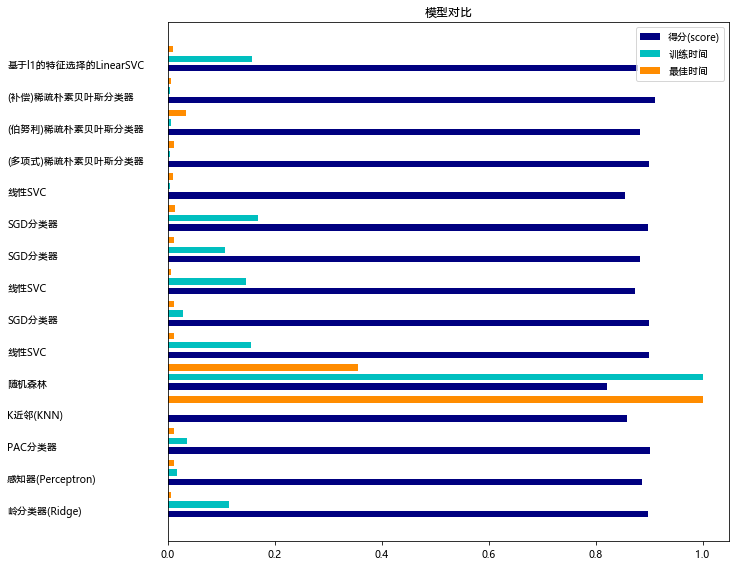